# Análise Exploratória das Estações Meteorológicas do Piauí

In [1]:
import warnings
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
path = 'shapefile/PI_Municipios_2022.shp'
pi= gpd.read_file(path).dissolve()

## Estações Convencionais e Automáticas do INMET

In [3]:
station_auto = pd.read_csv('CatalogoEstacoesAutomaticas.csv', sep =';', encoding= 'utf-8', decimal=',')
station_conv = pd.read_csv('CatalogoEstacoesConvencionais.csv', sep =';', encoding= 'utf-8', decimal=',')

In [4]:
station_pi_auto = station_auto[(station_auto.SG_ESTADO == 'PI') & (station_auto.CD_SITUACAO == 'Operante')]
station_pi_conv = station_conv[(station_conv.SG_ESTADO == 'PI') & (station_conv.CD_SITUACAO == 'Operante')]

In [5]:
station_pi_auto['TIPO'] = 'Automática'
station_pi_conv['TIPO'] = 'Convencional'

In [20]:
# Concatenando os dois DataFrames
station_pi = pd.concat([station_pi_auto, station_pi_conv], ignore_index=True)
station_pi.head()

,DC_NOME,SG_ESTADO,CD_SITUACAO,VL_LATITUDE,VL_LONGITUDE,VL_ALTITUDE,DT_INICIO_OPERACAO,CD_ESTACAO,TIPO
0,ALVORADA DO GURGUEIA,PI,Operante,-8.376389,-43.859444,225.00,16/11/2007,A336,Automática
1,BAIXA GRANDE DO RIBEIRO,PI,Operante,-8.333531,-45.094625,519.00,22/03/2018,A375,Automática
2,BOM JESUS DO PIAUI,PI,Operante,-9.080000,-44.327778,288.00,16/07/2007,A326,Automática
3,CAMPO MAIOR,PI,Operante,-4.864167,-42.145556,125.00,22/11/2018,A376,Automática
4,CANTO DO BURITI,PI,Operante,-8.118056,-42.975833,312.07,11/06/2010,A365,Automática


In [16]:
# Transformando o DataFrame em um GeoDataFrame
station_pi = gpd.GeoDataFrame(station_pi, geometry=gpd.points_from_xy(station_pi.VL_LONGITUDE, station_pi.VL_LATITUDE))

# Verificando a existências de mais de um estação com mesmo nome
# station_pi.DC_NOME.duplicated()

In [19]:
# Contabilizando as estações por TIPO
station_pi[['CD_SITUACAO', 'TIPO']].groupby(['TIPO']).count()

,CD_SITUACAO
TIPO,
Automática,18
Convencional,5


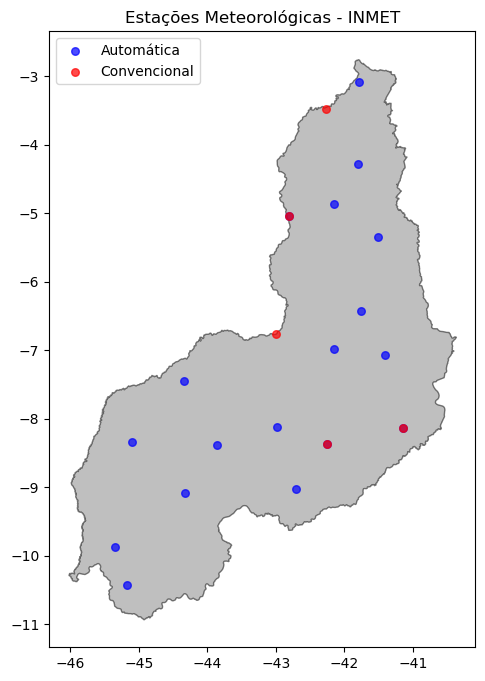

In [12]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot()
pi.plot(ax=ax, color='gray', alpha=0.5, edgecolor='k')

colors = {'Automática': 'blue', 'Convencional':'red'}
for tipo, color in colors.items():
    subset = station_pi[station_pi['TIPO'] == tipo]
    subset.plot(ax=ax, marker='o', color=color, markersize=30, label=tipo, alpha=0.7)
plt.title('Estações Meteorológicas - INMET')
plt.legend()
plt.show()

## Estações pluviométricas do banco de dados da ANA

In [9]:
stat = gpd.read_parquet('EstacoesFluvioPluvio_PiauiOperando.parquet')
stat.head(3)

,OBJECTID,Nome,TipoEstacao,TipoEstacaoCodigo,Operando,CodigoAdicional,Latitude,Longitude,Altitude,AreaDrenagem,...,RedeNavegacao,RedeCursoDagua,RedeEstrategica,RedeCaptacao,RedeRHNR,RedeQA,RedeClasseVazao,Descricao,DataAlteracao,geometry
1599,1600,FAZENDA BANANEIRA,Fluviométrica,1,Sim,None,-10.0164,-45.0247,420.0,681.0,...,Não,Nulo,Não,Nulo,Não,Não,Sim,None,NaT,POINT (-45.02470 -10.01640)
1601,1602,BARROCÃO,Fluviométrica,1,Sim,None,-9.8819,-45.2328,392.0,916.0,...,Não,Nulo,Não,Nulo,Não,Não,Sim,None,NaT,POINT (-45.23280 -9.88190)
1602,1603,CONTRATO,Fluviométrica,1,Sim,None,-9.5800,-45.0292,341.0,750.0,...,Não,Nulo,Não,Nulo,Não,Nulo,Sim,None,2022-02-16,POINT (-45.02920 -9.58000)


In [23]:
stat_plu = stat[stat.TipoEstacao == 'Pluvometrica']
stat_plu.head(3)

,OBJECTID,Nome,TipoEstacao,TipoEstacaoCodigo,Operando,CodigoAdicional,Latitude,Longitude,Altitude,AreaDrenagem,...,RedeNavegacao,RedeCursoDagua,RedeEstrategica,RedeCaptacao,RedeRHNR,RedeQA,RedeClasseVazao,Descricao,DataAlteracao,geometry
13534,13535,PIRACURUCA,Pluvometrica,2,Sim,2776859,-3.9333,-41.7167,70.0,NaN,...,Não,Não,Não,Nulo,Não,Não,Não,None,2010-04-28,POINT (-41.71670 -3.93330)
13544,13545,CONGOS,Pluvometrica,2,Sim,None,-3.9833,-41.9500,NaN,NaN,...,Não,Nulo,Não,Nulo,Não,Não,Não,None,2010-04-28,POINT (-41.95000 -3.98330)
13549,13550,CARRASCO (BARRA DO LONGA),Pluvometrica,2,Sim,None,-3.1500,-41.9333,NaN,NaN,...,Não,Nulo,Não,Nulo,Não,Não,Não,None,2010-04-28,POINT (-41.93330 -3.15000)


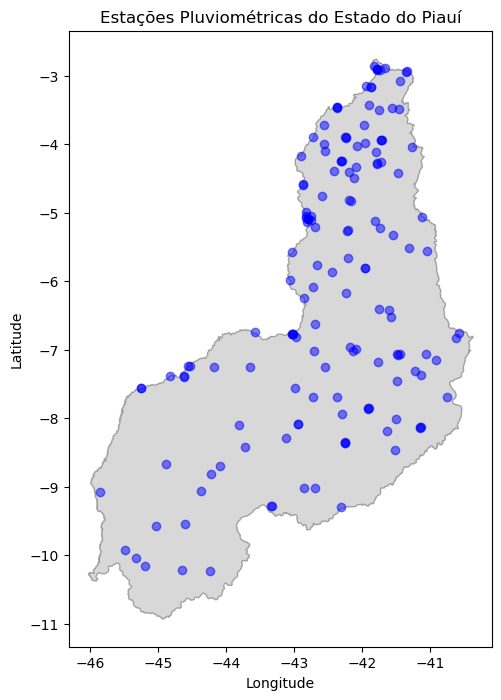

In [11]:
#Visualização
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot()
pi.plot(ax=ax1, color = 'gray', alpha=0.3, edgecolor='k')
#station_pi_auto_loc.plot(ax=ax1, marker='*', color='red')
stat_plu.plot(ax=ax1, color='blue', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Estações Pluviométricas do Estado do Piauí')
plt.show()